<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/carbon_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Firm-specific emissions and portfolio analysis

This notebook presents data on corporate emissions and shows what can happen if they are taken into account in a framework of **modern portfolio theory**.

### Libraries & data

In [2]:
import pandas as pd
import numpy as np                       # For vector/matrix manipulation
from numpy.linalg import inv             # For matrix inversion
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # For dynamic plots
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown


We downloaded data for the following firms (except Apple - to be corrected): 

|A - F| G - M |O - Z|
| --- | ----- | --- |
| AAPL (Apple)| GE (General Electric) | ORCL (Oracle)
| BA (Boeing) | HD (Home Depot) | PFE (Pfizer)
| BAC (Bank of America) | IBM | PG (Procter & Gamble)
| C (Citigroup) | INTC (Intel) | T (AT&T)
|CSCO (Cisco) | JNJ (Johnson & Johnson) |  UNH (United Health)
|CVS (CVS Health) | JPM (JP Morgan) | UPS 
|CVX (Chevron) | K (Kellogg) | VZ (Verizon)
|D (Dominion Energy) | MCK (McKesson) | WFC (Wells Fargo)
|DIS (Disney) | MRK (Merck) | WMT (Walmart)
|F (Ford) | MSFT (Microsoft) | XOM (Exxon)

The data is stored in a .xlsx file on **Github**.  
We move toward the coding part & start by loading the libraries/packages/modules.



In [3]:
url = 'https://github.com/shokru/carbon_emissions/blob/main/data_fin.xlsx?raw=true'
data = pd.read_excel(url)
data

,Company,Date,Price,Mkt_cap,Energy_consumption,GHG_scope_3,GHG_total,Return,Year
0,AAPL,2005-12-30,2.2050,60586.5831,NaN,NaN,NaN,1.232609,2005
1,AAPL,2006-12-29,2.6020,72900.7792,NaN,NaN,NaN,0.180136,2006
2,AAPL,2007-12-31,6.0740,173427.0193,265.684,NaN,NaN,1.334748,2007
...,...,...,...,...,...,...,...,...,...
486,XOM,2018-12-31,57.5328,288703.3109,416667.000,NaN,127000.0,-0.151017,2018
487,XOM,2019-12-31,61.6941,295246.5813,416667.000,730000.0,123000.0,0.072517,2019
488,XOM,2020-12-31,39.3540,174287.8102,416667.000,730000.0,123000.0,-0.362131,2020


There are some **missing points**, mostly at the beginning of the sample, because the later missing points have been replaced by the last well-defined value (up to 5 years).  
The data is not raw and has been pre-processed.  
**NOTE**: "total" emissions are direct plus indirect emissions (i.e., scope 1&2), while "scope 3" emissions encompass those from the whole value chain. Energy consumption is in thousands of megawatt hours (MWh).     

### Initial plots
We plot some values below.


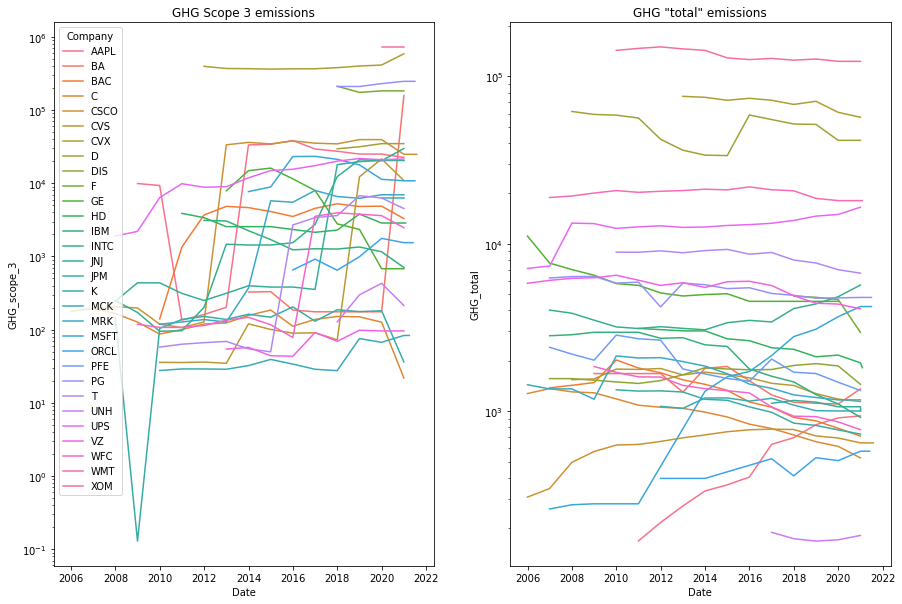

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.lineplot(
    ax = ax[0],
    data = data,            # Data source = the filtered data (other method)
    x = "Date",             # x-axis = Date column (of course!)
    y = "GHG_scope_3",      # y-axis = the normalised Close column
    hue = "Company"         # One color for each sector
)
ax[0].set_yscale('log')
ax[0].set_title('GHG Scope 3 emissions')
sns.lineplot(
    ax = ax[1],
    data = data,            # Data source = the filtered data (other method)
    x = "Date",             # x-axis = Date column (of course!)
    y = "GHG_total",        # y-axis = the normalised Close column
    hue = "Company"         # One color for each sector
)
ax[1].set_yscale('log')
ax[1].set_title('GHG "total" emissions')
ax[1].get_legend().remove()

**Comment**: "total" emission curves are smoother.  
Also, disclosure is very firm-specific. Some started early, others later.
Let's sort them into 2 groups: the **green** and the **brown**.   
Green companies have total emissions below the median and it's the opposite for the brown ones.

In [5]:
data['Type'] = data.groupby('Date')['GHG_total'].transform(lambda x: x < x.median()).astype(int)
data['Type'] = data['Type'].replace(0, "Brown")
data['Type'] = data['Type'].replace(1, "Green")
data

,Company,Date,Price,Mkt_cap,Energy_consumption,GHG_scope_3,GHG_total,Return,Year,Type
0,AAPL,2005-12-30,2.2050,60586.5831,NaN,NaN,NaN,1.232609,2005,Brown
1,AAPL,2006-12-29,2.6020,72900.7792,NaN,NaN,NaN,0.180136,2006,Brown
2,AAPL,2007-12-31,6.0740,173427.0193,265.684,NaN,NaN,1.334748,2007,Brown
...,...,...,...,...,...,...,...,...,...,...
486,XOM,2018-12-31,57.5328,288703.3109,416667.000,NaN,127000.0,-0.151017,2018,Brown
487,XOM,2019-12-31,61.6941,295246.5813,416667.000,730000.0,123000.0,0.072517,2019,Brown
488,XOM,2020-12-31,39.3540,174287.8102,416667.000,730000.0,123000.0,-0.362131,2020,Brown


Let's visualize that to check.

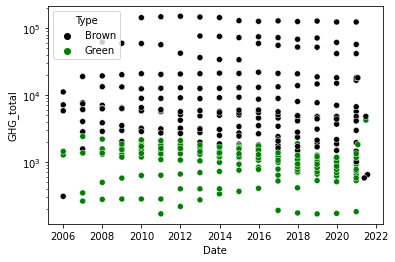

In [6]:
sns.scatterplot(
    data = data,
    x = 'Date',
    y = 'GHG_total',
    hue = 'Type',
    palette = ['black', 'green']
)
plt.yscale('log')

A few errors, but ok overall.

In [7]:
fig = px.scatter(data, 
                 x="Year",
                 y="GHG_total", 
                 color="Type",
                 color_discrete_sequence = ['#666666', '#00CC66'],
                 hover_data=['Company'],
                 log_y = True)
fig.show()

Finally, let's have a look at some recent emission values of all firms.
We use log-scales for readability purposes.

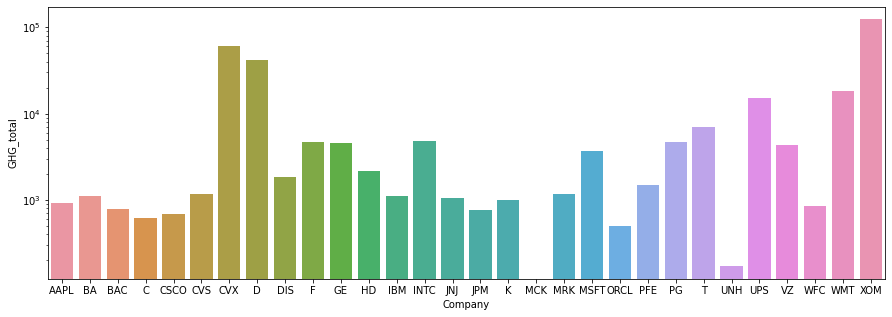

In [8]:
f , ax = plt.subplots(figsize=(15, 5))
ax.set(yscale="log")

sns.barplot(data = data.query('Year == 2019'),
            ax = ax,
            x = 'Company',
            y = 'GHG_total')


We see that Merck has not disclosed emission data for 2019, and in fact, for any year.  
Though a few scope 3 points are available, surprisingly.  
This will be an issue subsequently and we will have to impute...


### Profitability & risk

Next, we turn to the financial performance of the stocks.  
We are shifting to the pecuniary part of our analysis.

In [9]:
mu_vector = data.pivot_table(index = 'Company', values = 'Return', aggfunc = 'mean')
mu_vector

,Return
Company,
AAPL,0.467784
BA,0.172010
BAC,0.076952
...,...
WFC,0.047988
WMT,0.109172
XOM,0.035225


Let's plot this...

In [10]:
fig = px.bar(mu_vector.reset_index(), 
             y = 'Return', x = 'Company')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

How about volatility (as a proxy for risk)?

In [11]:
fig = px.bar(data.pivot_table(index = 'Company', values = 'Return', aggfunc = np.std).reset_index(), 
             y = 'Return', x = 'Company')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_traces(marker_color = 'red')
fig.show()

Now let's look at correlations.


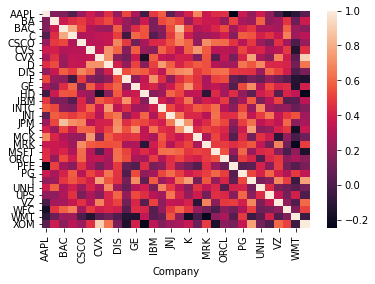

In [12]:
Corr_mat = data.pivot(index = 'Year', columns = 'Company', values = 'Return').fillna(0).corr().reset_index(drop=True)
Cov_mat = data.pivot(index = 'Year', columns = 'Company', values = 'Return').fillna(0).cov().reset_index(drop=True)

sns.heatmap(Corr_mat,
            yticklabels = data['Company'].unique())
sns.set(rc={'figure.figsize':(11,7)})

### How to invest?

#### If we don't care about emissions

The portfolio that maximizes the Sharpe ratio is proportional to $\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}$ - assuming zero interest rates (which is not a major issue in recent times).  
In this case, some assets will have negative weights, which means that it seems optimal to sell them short (though, in practice, this is rarely done).  
Let's have a look at the portfolio that would have been optimal if we had known the full history 2015-2021.

In [13]:
w = np.dot(inv(Cov_mat.to_numpy() + 0.1*np.identity(30)), mu_vector.to_numpy()) # We use shrinkage because the matrix is singular
w = w / sum(w)
w = np.concatenate(w)
w

array([ 0.18707626,  0.03601441, -0.04740887, -0.13104284, -0.01393511,
        0.01709558,  0.03857643,  0.02929774,  0.10495068, -0.07387131,
       -0.08764205,  0.18463295, -0.01698652, -0.05600751,  0.05706445,
        0.07518016,  0.01316541, -0.00667987,  0.03837651,  0.09359906,
        0.06646596,  0.0633055 ,  0.04362039,  0.04138137,  0.0764993 ,
        0.01643579,  0.08226804,  0.06592874,  0.09649338,  0.00614596])

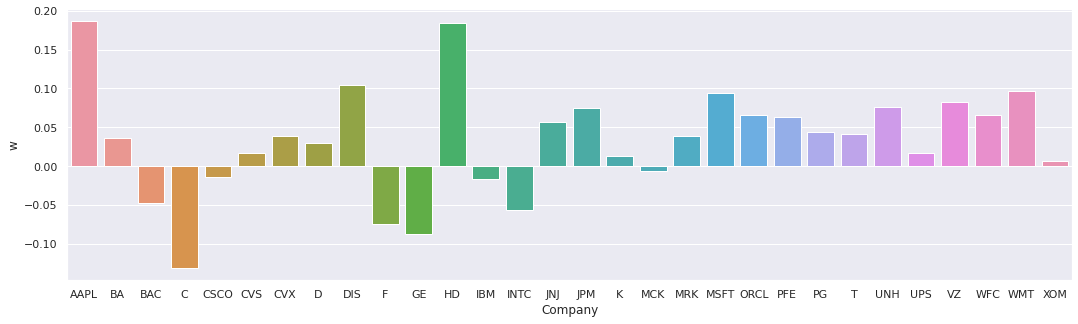

In [18]:
sns.barplot(data = pd.DataFrame({'Company' : data['Company'].unique(),
                                 'w' : w}),
            x = 'Company', y = 'w')
sns.set(rc={'figure.figsize':(18,5)})

#### Including emissions in the decision process
Ok, so now let's look at what would happen if we take emissions into consideration.  
First, let's extract them from the data & impute.

In [15]:
emissions = data.query('Year == 2019')['GHG_total']
# Here we impute a value for Merck: the average of all 29 stocks (probably a bad choice)
emissions = emissions.fillna(np.mean(emissions)).to_numpy() 
emissions = emissions/sum(emissions)
emissions

array([0.00284696, 0.00344692, 0.00246871, 0.00192435, 0.00215946,
       0.00368649, 0.19028238, 0.129475  , 0.00581884, 0.0144978 ,
       0.01414016, 0.00675035, 0.00344626, 0.01508066, 0.00331806,
       0.00241426, 0.00313186, 0.03333333, 0.00364625, 0.01144804,
       0.00158153, 0.00464788, 0.0148298 , 0.02185465, 0.00053252,
       0.046719  , 0.01361807, 0.00269303, 0.05652323, 0.38368415])

In order to penalize the stocks with large emissions, the easiest way is to shrink their returns.

In [19]:
w_em = np.dot(inv(Cov_mat.to_numpy() + 0.1*np.identity(30)),          # We use shrinkage because the matrix is singular
              np.concatenate(mu_vector.to_numpy())- 0.3 * emissions)  # We remove emissions! 
w_em = w_em / sum(w_em)
w_em

array([ 0.22323996,  0.06320046, -0.05665145, -0.14221559, -0.01143713,
        0.03256543, -0.01013732, -0.0077541 ,  0.11971405, -0.0956601 ,
       -0.09025645,  0.19711753,  0.00342451, -0.06076244,  0.0717544 ,
        0.09295604,  0.01963848, -0.01511742,  0.05843902,  0.09132578,
        0.08565306,  0.07268141,  0.05234471,  0.06718409,  0.09293323,
        0.00222645,  0.10597823,  0.09145946,  0.09042057, -0.1442649 ])

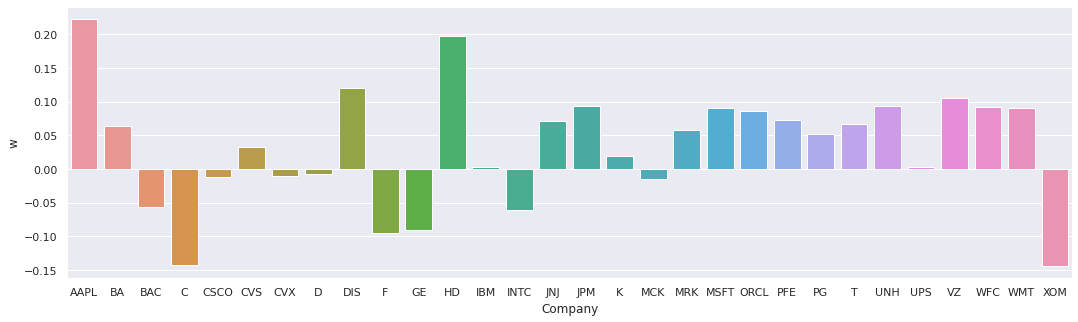

In [20]:
sns.barplot(data = pd.DataFrame({'Company' : data['Company'].unique(),
                                 'w' : w_em}),
            x = 'Company', y = 'w')
sns.set(rc={'figure.figsize':(18,5)})

Chevron (CVX), at more markedly, Exxon Mobile (XOM) see their weights shrink...
What's the impact on performance?

In [27]:
sum(np.concatenate(mu_vector.to_numpy()) * w)

0.22423232315968836

In [28]:
sum(np.concatenate(mu_vector.to_numpy()) * w_em)

0.25063447073091094

Ha! Higher return for the emissions-corrected portfolio.  
However, this comes with higher risk... 

In [30]:
np.dot(np.transpose(w),np.dot(Cov_mat, w))

0.014429149907657908

In [31]:
np.dot(np.transpose(w_em),np.dot(Cov_mat, w_em))

0.0183909841647429

For a review on the relationship between ESG criteria and financial performance, we point to [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3715753).